Epoch 1/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 178ms/step - items_output_loss: 0.8276 - items_output_mae: 1.2233 - loss: 2.0804 - sales_output_loss: 1.2990 - sales_output_mae: 1.6979 - val_items_output_loss: 0.0125 - val_items_output_mae: 0.1185 - val_loss: 0.0254 - val_sales_output_loss: 0.0128 - val_sales_output_mae: 0.1309 - learning_rate: 0.0100
Epoch 2/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - items_output_loss: 0.5727 - items_output_mae: 0.9060 - loss: 1.3149 - sales_output_loss: 0.7447 - sales_output_mae: 1.1372 - val_items_output_loss: 0.0060 - val_items_output_mae: 0.0953 - val_loss: 0.0173 - val_sales_output_loss: 0.0113 - val_sales_output_mae: 0.1634 - learning_rate: 0.0100
Epoch 3/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - items_output_loss: 0.4796 - items_output_mae: 0.8312 - loss: 1.0497 - sales_output_loss: 0.5704 - sales_output_mae: 0.9457 - val_items_output_loss: 0.0111 - val_items_output_mae: 0.1391 - val_loss: 0.0208 - val_sales_output_loss: 0.0097 - val_sales_output_mae: 0

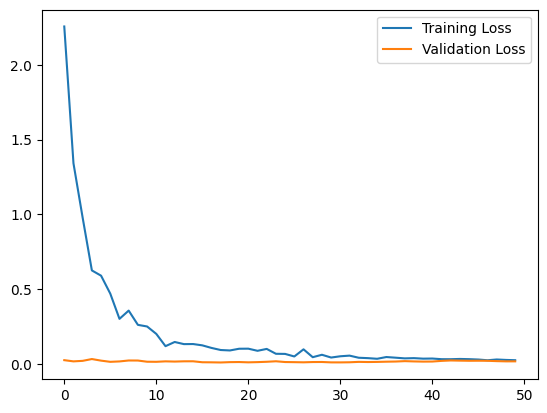

In [9]:
import json
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import requests

# Load data from the raw GitHub file link
url = 'https://raw.githubusercontent.com/matthog/MLHW/refs/heads/main/output.json'
response = requests.get(url)
data = response.json()

# Prepare data
locations = []
square_footage = []
property_values = []
target_sales = []
item_totals = []
time_of_year = []

for key, entry in data.items():
    locations.append([entry['coordinates']['latitude'], entry['coordinates']['longitude']])
    square_footage.append(entry['square_footage'])
    property_values.append(entry['property_value'])
    target_sales.append(entry['csv_data']['total_sales'])
    item_totals.append(entry['csv_data']['total_items_sold'])
    time_of_year.append(entry['sale_date'])

# Convert to numpy arrays
locations = np.array(locations)
square_footage = np.array(square_footage).reshape(-1, 1)
property_values = np.array(property_values).reshape(-1, 1)
time_of_year = np.array(time_of_year)
target_sales = np.array(target_sales)
item_totals = np.array(item_totals)

# Cyclical encoding for time of year (month)
# Map month names to numbers
month_to_num = {
    "January": 1, "February": 2, "March": 3, "April": 4,
    "May": 5, "June": 6, "July": 7, "August": 8,
    "September": 9, "October": 10, "November": 11, "December": 12
}

# Extract and map the sale_date (month names) to numbers
time_of_year = [month_to_num[entry['sale_date']] for key, entry in data.items()]

# Convert time_of_year to a numpy array and ensure numeric type
time_of_year = np.array(time_of_year, dtype=float)

# Cyclical encoding for time of year (month)
time_of_year_sin = np.sin(2 * np.pi * time_of_year / 12)
time_of_year_cos = np.cos(2 * np.pi * time_of_year / 12)
time_of_year_encoded = np.column_stack((time_of_year_sin, time_of_year_cos))

# Normalize other features using StandardScaler
scaler = StandardScaler()
square_footage = scaler.fit_transform(square_footage)
property_values = scaler.fit_transform(property_values)
locations = scaler.fit_transform(locations)

# Combine all features into a single input array
features = np.hstack([square_footage, property_values, locations, time_of_year_encoded])

# Scale target_sales and item_totals using Min-Max scaling
sales_scaler = MinMaxScaler()
items_scaler = MinMaxScaler()

# Fit the scaler to the target values (sales and items)
target_sales_scaled = sales_scaler.fit_transform(target_sales.reshape(-1, 1))
item_totals_scaled = items_scaler.fit_transform(item_totals.reshape(-1, 1))

# Split data into training and testing sets
X_train, X_test, y_train_sales, y_test_sales = train_test_split(
    features, target_sales_scaled, test_size=0.1, random_state=42
)
_, _, y_train_items, y_test_items = train_test_split(
    features, item_totals_scaled, test_size=0.1, random_state=42
)

# Build the neural network model with additional layers
def build_model(input_dim):
    input_layer = tf.keras.Input(shape=(input_dim,))
    dense1 = tf.keras.layers.Dense(128, activation='relu')(input_layer)
    batch_norm1 = tf.keras.layers.BatchNormalization()(dense1)
    dense2 = tf.keras.layers.Dense(128, activation='relu')(batch_norm1)
    batch_norm2 = tf.keras.layers.BatchNormalization()(dense2)
    dropout = tf.keras.layers.Dropout(0.3)(batch_norm2)

    output_sales = tf.keras.layers.Dense(1, name='sales_output')(dropout)
    output_items = tf.keras.layers.Dense(1, name='items_output')(dropout)

    model = tf.keras.Model(inputs=input_layer, outputs=[output_sales, output_items])
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
        loss={'sales_output': 'Huber', 'items_output': 'Huber'},
        metrics={'sales_output': ['mae'], 'items_output': ['mae']}
    )
    return model

model = build_model(features.shape[1])

# Train the model with callbacks (only reduce_lr for dynamic learning rate adjustment)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.9, patience=10, min_lr=1e-6
)

# Train the model without early stopping
history = model.fit(
    X_train,
    {'sales_output': y_train_sales, 'items_output': y_train_items},
    validation_data=(X_test, {'sales_output': y_test_sales, 'items_output': y_test_items}),
    epochs=50,  # Train for much longer if necessary
    batch_size=32,
    callbacks=[reduce_lr],  # Only reduce_lr callback
    verbose=1
)

# Evaluate the model
evaluation = model.evaluate(X_test, {'sales_output': y_test_sales, 'items_output': y_test_items})
print("\nEvaluation Results:", evaluation)

# Predictions
pred_sales, pred_items = model.predict(X_test)

# Reverse the scaling of predictions
pred_sales_unscaled = sales_scaler.inverse_transform(pred_sales)
pred_items_unscaled = items_scaler.inverse_transform(pred_items)

# Calculate RMSE for better interpretability
rmse_sales = np.sqrt(mean_squared_error(y_test_sales, pred_sales_unscaled))
rmse_items = np.sqrt(mean_squared_error(y_test_items, pred_items_unscaled))
print(f"\nRMSE for Sales: {rmse_sales}")
print(f"RMSE for Items Sold: {rmse_items}")

# Display actual vs predicted values
print("\nActual vs Predicted Sales:")
for actual, predicted in zip(sales_scaler.inverse_transform(y_test_sales)[:10].flatten(), pred_sales_unscaled.flatten()[:10]):
    print(f"Actual: {actual:.2f}, Predicted: {predicted:.2f}")

print("\nActual vs Predicted Items:")
for actual, predicted in zip(items_scaler.inverse_transform(y_test_items)[:10].flatten(), pred_items_unscaled.flatten()[:10]):
    print(f"Actual: {actual:.2f}, Predicted: {predicted:.2f}")

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()